#### **https://pmorissette.github.io/bt/**

In [1]:
import pandas as pd
import numpy as np
import bt

In [2]:
df_prices = pd.read_excel("all_data/data.xlsx")
print(len(df_prices.columns))
df_prices.columns

df_prices = df_prices.drop('sp_500', axis=1)

# Convert Date to datetime
df_prices['Date'] = pd.to_datetime(df_prices['Date'])

# Filter dates from 01/11/2011
df_prices = df_prices[df_prices['Date'] >= '2012-03-01']

47


In [3]:
df_prices.head()

,Date,AAPL,ABT,AMD,AMZN,AVGO,AXP,BAC,BRK-B,CAT,...,PM,QCOM,RTX,TMO,TMUS,UNH,V,WFC,WMT,XOM
566,2012-03-01,16.345051,20.967695,7.51,9.0020,2.673969,44.247559,6.387696,78.779999,79.848244,...,43.879776,43.663567,38.436684,54.191261,17.488312,45.223148,26.605352,21.517309,14.804693,50.725281
567,2012-03-02,16.366367,20.993307,7.46,8.9650,2.622381,43.768497,6.395563,78.290001,79.214455,...,44.046474,43.538029,38.610226,54.257599,16.989565,45.101986,26.373768,21.339930,14.852518,50.433186
568,2012-03-05,16.005524,20.953077,7.07,9.0130,2.539984,43.751980,6.269697,79.169998,77.524429,...,44.499699,43.314857,38.039360,53.603683,16.024248,44.455830,26.391928,21.128447,14.950685,50.830437
569,2012-03-06,15.918466,20.612873,6.90,9.0545,2.529953,42.736023,6.065166,78.470001,74.594978,...,43.791214,42.931305,37.171597,52.532734,15.525503,43.987370,26.074060,20.541729,14.842444,50.158615
570,2012-03-07,15.931372,20.579954,7.17,9.1885,2.561479,43.173790,6.309031,78.820000,76.249825,...,43.796417,43.740280,37.710526,52.362137,15.847277,43.930813,26.255705,20.746399,15.066462,50.141075


In [4]:
gw = pd.read_excel("all_data/weights_garch.xlsx")
hw = pd.read_excel("all_data/weights_hist.xlsx")

In [5]:
df_prices.set_index('Date', inplace=True)

print("Prices shape:", df_prices.shape)
print("Prices date range:", df_prices.index.min(), "to", df_prices.index.max())
print("Prices columns:", df_prices.columns.tolist())

Prices shape: (3415, 45)
Prices date range: 2012-03-01 00:00:00 to 2025-09-29 00:00:00
Prices columns: ['AAPL', 'ABT', 'AMD', 'AMZN', 'AVGO', 'AXP', 'BAC', 'BRK-B', 'CAT', 'COST', 'CRM', 'CSCO', 'CVX', 'DIS', 'GE', 'GOOG', 'GOOGL', 'GS', 'HD', 'IBM', 'JNJ', 'JPM', 'KO', 'LLY', 'LRCX', 'MA', 'MCD', 'MRK', 'MS', 'MSFT', 'MU', 'NFLX', 'NVDA', 'ORCL', 'PG', 'PM', 'QCOM', 'RTX', 'TMO', 'TMUS', 'UNH', 'V', 'WFC', 'WMT', 'XOM']


In [6]:
# ===== STEP 3: PREPARE WEIGHTS DATA =====
# Convert month-year strings to datetime (first day of month)
gw['Date'] = pd.to_datetime(gw['Date'], format='%m-%Y')
hw['Date'] = pd.to_datetime(hw['Date'], format='%m-%Y')

# Set Date as index
gw.set_index('Date', inplace=True)
hw.set_index('Date', inplace=True)

print("\nGARCH weights shape:", gw.shape)
print("GARCH weights date range:", gw.index.min(), "to", gw.index.max())
print("\nHistorical weights shape:", hw.shape)
print("Historical weights date range:", hw.index.min(), "to", hw.index.max())


GARCH weights shape: (161, 45)
GARCH weights date range: 2012-03-01 00:00:00 to 2025-07-01 00:00:00

Historical weights shape: (163, 45)
Historical weights date range: 2012-03-01 00:00:00 to 2025-09-01 00:00:00


In [7]:
# ===== STEP 4: EXPAND MONTHLY WEIGHTS TO DAILY =====
# This is the KEY step: map each daily price date to its corresponding monthly weight
# Forward-fill monthly weights to apply throughout each month

gw_daily = gw.reindex(df_prices.index, method='ffill')
hw_daily = hw.reindex(df_prices.index, method='ffill')

print("\nGARCH daily weights shape:", gw_daily.shape)
print("Historical daily weights shape:", hw_daily.shape)

# Check for any NaN values (shouldn't be any in the overlapping period)
print("\nGARCH weights NaN count:", gw_daily.isna().sum().sum())
print("Historical weights NaN count:", hw_daily.isna().sum().sum())


GARCH daily weights shape: (3415, 45)
Historical daily weights shape: (3415, 45)

GARCH weights NaN count: 0
Historical weights NaN count: 0


In [8]:
# ===== STEP 5: CREATE BT STRATEGIES =====

# Strategy 1: GARCH-based weights
garch_strategy = bt.Strategy(
    'GARCH_Portfolio',
    [
        bt.algos.RunMonthly(),              # Rebalance on first trading day of month
        bt.algos.SelectAll(),                # Select all stocks
        bt.algos.WeighTarget(gw_daily),     # Apply pre-calculated GARCH weights
        bt.algos.Rebalance()                 # Execute rebalancing trades
    ]
)

# Strategy 2: Historical volatility-based weights
hist_strategy = bt.Strategy(
    'Historical_Portfolio',
    [
        bt.algos.RunMonthly(),              # Rebalance on first trading day of month
        bt.algos.SelectAll(),                # Select all stocks
        bt.algos.WeighTarget(hw_daily),     # Apply pre-calculated historical weights
        bt.algos.Rebalance()                 # Execute rebalancing trades
    ]
)

In [9]:
# ===== STEP 6: CREATE BACKTESTS =====
garch_backtest = bt.Backtest(
    garch_strategy, 
    df_prices,
    initial_capital=1000000,  # Starting with $1 million
)

hist_backtest = bt.Backtest(
    hist_strategy, 
    df_prices,
    initial_capital=1000000,
)

# ===== STEP 7: RUN BACKTESTS =====
print("\n" + "="*80)
print("RUNNING BACKTESTS...")
print("="*80)

results = bt.run(garch_backtest, hist_backtest)


RUNNING BACKTESTS...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


In [10]:
print(results.stats)

                           GARCH_Portfolio Historical_Portfolio
start                  2012-02-29 00:00:00  2012-02-29 00:00:00
end                    2025-09-29 00:00:00  2025-09-29 00:00:00
rf                                     0.0                  0.0
total_return                     20.628045            20.059053
cagr                              0.253977             0.251518
max_drawdown                     -0.259655            -0.301412
calmar                            0.978134             0.834468
mtd                               0.088466             0.112111
three_month                       0.140202             0.160404
six_month                         0.177247             0.212818
ytd                               0.091822             0.125838
one_year                          0.095527             0.151331
three_year                        0.307389             0.309244
five_year                         0.261144             0.252848
ten_year                          0.2812

<Axes: title={'center': 'Portfolio Performance: GARCH vs Historical Volatility'}>

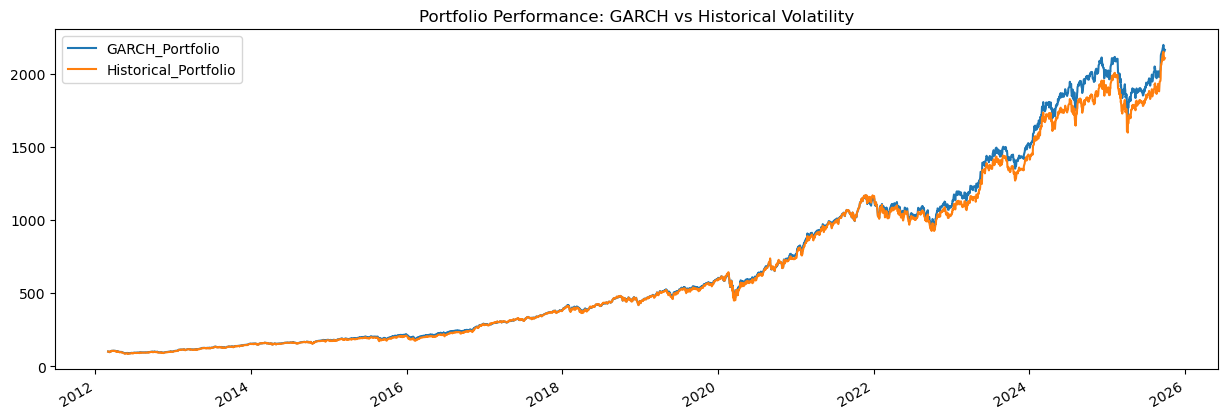

In [11]:
results.plot(title='Portfolio Performance: GARCH vs Historical Volatility')